# NLP DIsaster Tweets Kaggle Mini-Project

## 1. Preparation for data

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import keras
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D, Dropout, Bidirectional, GRU
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')
import os

In [6]:
train= pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train.head()
#print(test.head())

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## (1) EDA

In [7]:
train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

<Axes: ylabel='target'>

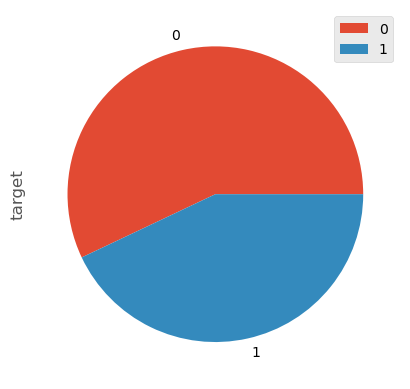

In [8]:
train.target.value_counts().plot.pie(legend=True)

### # of characters

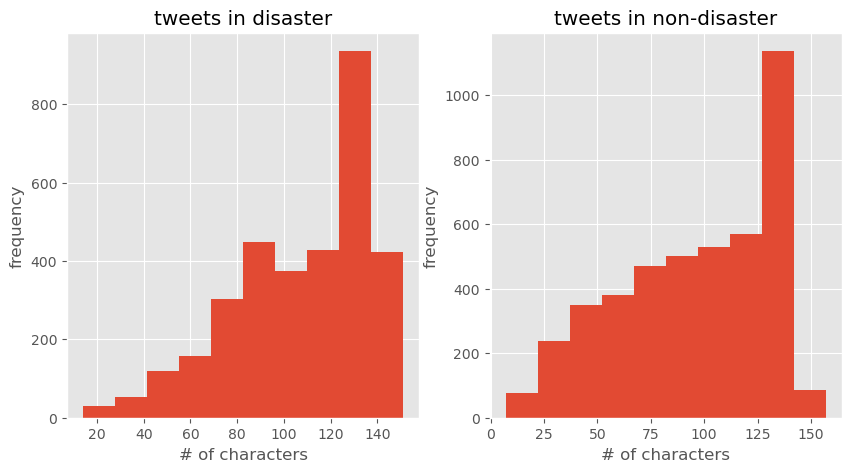

In [9]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.hist(train[train['target']==1]['text'].str.len())
ax1.set_title('tweets in disaster')
ax1.set_xlabel('# of characters')
ax1.set_ylabel('frequency')
ax2.hist(train[train['target']==0]['text'].str.len())
ax2.set_title('tweets in non-disaster')
ax2.set_xlabel('# of characters')
ax2.set_ylabel('frequency')
plt.show()

### # of words

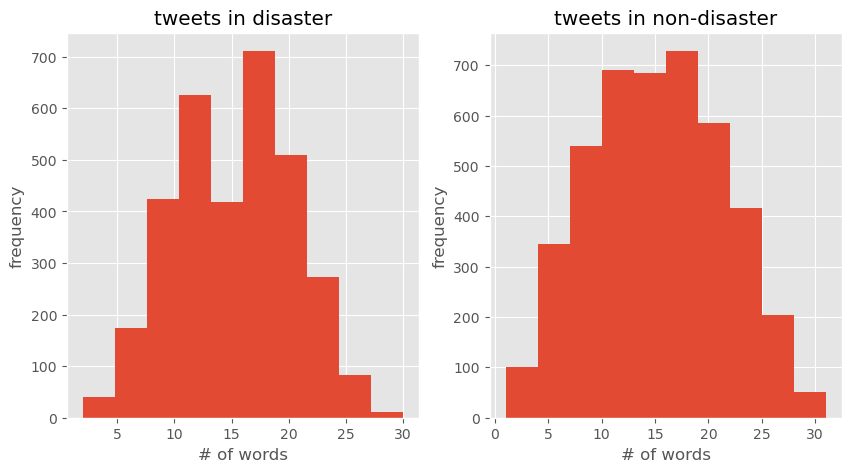

In [10]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.hist(train[train['target']==1]['text'].str.split().map(lambda x: len(x)))
ax1.set_title('tweets in disaster')
ax1.set_xlabel('# of words')
ax1.set_ylabel('frequency')
ax2.hist(train[train['target']==0]['text'].str.split().map(lambda x: len(x)))
ax2.set_title('tweets in non-disaster')
ax2.set_xlabel('# of words')
ax2.set_ylabel('frequency')
plt.show()

### As there does not seem to be any disparity between disaster and non-disaster exists in training data, any normalization to the data would not be necessary. 

## (2) data cleaning

### (i) remove emoji
### (ii) remove punctuation
### (iii) translate abbreviation into ordinal expression

In [11]:
# remove links and non-ascii characters
def clean_text(text):
    text = ''.join([x for x in text if x in string.printable])
    text = re.sub(r"http\S+","",text)

    # emoji 
    emoji = re.compile("["
                     u"\U0001F600-\U0001F64F"  # emoticons
                     u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                     u"\U0001F680-\U0001F6FF"  # transport & map symbols
                     u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                     u"\U00002702-\U000027B0"
                     u"\U000024C2-\U0001F251"
                     "]+", flags=re.UNICODE
                     )
    text = emoji.sub(r'', text)
    
    #remove punctuation
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        text = text.replace(p, f' {p} ')
    
    return text

In [12]:
train["clean_text"] = train["text"].apply(lambda x: clean_text(x))
train.head()
test["clean_text"] =test["text"].apply(lambda x: clean_text(x))

In [13]:
## https://www.kaggle.com/code/rftexas/text-only-bert-keras?scriptVersionId=31186559
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [14]:
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

In [15]:
train["clean_text2"] = train["clean_text"].apply(lambda x: convert_abbrev_in_text(x))
test["clean_text2"] = test["clean_text"].apply(lambda x: convert_abbrev_in_text(x))
train.head()

,id,keyword,location,text,target,clean_text,clean_text2
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this # earthquake...,Our Deeds are the Reason of this # earthquake ...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask . Canada,Forest fire near La Ronge Sask . Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to ' shelter in place ' ...,All residents asked to ' shelter in place ' ar...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive # wildfires evacuation ...","13,000 people receive # wildfires evacuation o..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby # Alaska a...,Just got sent this photo from Ruby # Alaska as...


### check word frequency in the text

In [16]:
def corpus(text):
    lst = []
    for x in text.str.split():
        for i in x:
            lst.append(i)
    
    dic = defaultdict(int)
    return lst

In [17]:
counter=Counter(corpus(train["clean_text2"]))
most=counter.most_common()
most[:30]

[('.', 6964),
 ('#', 3403),
 ("'", 3148),
 ('?', 3125),
 ('@', 2758),
 ('the', 2619),
 (':', 2181),
 ('a', 1887),
 ('to', 1820),
 ('in', 1785),
 ('-', 1751),
 ('of', 1741),
 ('I', 1601),
 ('and', 1332),
 ('!', 1172),
 ('you', 895),
 ('for', 838),
 ('is', 827),
 ('on', 811),
 ('s', 793),
 ('it', 614),
 ('my', 605),
 ('The', 592),
 (';', 587),
 ('that', 555),
 ('with', 518),
 ('at', 494),
 ('by', 477),
 ('t', 463),
 ('&', 457)]

### As the above shows, the feature of frequent words are less than 3 character. So I remove words the length of which is less than 3, and also remove "stopwords" 

### (iv) remove word the length of which is less than 3, and remove stop words

In [18]:
# drop word whose length is l.t 3  ## lower case  ### remove stop words

train["clean_text3"] = train["clean_text2"].apply(lambda x: ' '.join([w for w in x.split() if len(w) >3]))

train["clean_text3"] = train["clean_text3"].str.lower()

train["tokenize"] = train.apply(lambda row: nltk.word_tokenize(row["clean_text3"]), axis = 1)

def remove_stop(row):
    return [w for w in row['tokenize'] if w not in stop]

train["clean_text_lst"] = train.apply(remove_stop, axis = 1)

def rejoin_words(row):
    return (" ".join(row["clean_text_lst"]))

train["clean_text_join"] = train.apply(rejoin_words, axis = 1)

counter=Counter(corpus(train[train['target']==0]["clean_text_join"]))
most=counter.most_common()
most[:30]

[('like', 254),
 ('body', 116),
 ('people', 105),
 ('would', 101),
 ('video', 96),
 ('loud', 95),
 ('know', 91),
 ('love', 90),
 ('time', 88),
 ('back', 88),
 ('full', 84),
 ('emergency', 81),
 ('going', 76),
 ('youtube', 76),
 ('fire', 72),
 ('still', 71),
 ('good', 70),
 ('want', 67),
 ('laughing', 66),
 ('think', 66),
 ('retweet', 63),
 ('world', 63),
 ('life', 61),
 ('first', 59),
 ('work', 58),
 ('news', 58),
 ('burning', 57),
 ('last', 56),
 ('make', 55),
 ('best', 55)]

In [19]:
train[train['target']==0]["clean_text_join"].head()

15                   
16        love fruits
17      summer lovely
18               fast
19    goooooooaaaaaal
Name: clean_text_join, dtype: object

In [20]:
test["clean_text3"] = test["clean_text2"].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))
test["clean_text3"] = test["clean_text3"].str.lower()

test["tokenize"] = test.apply(lambda row: nltk.word_tokenize(row["clean_text3"]), axis = 1)

test["clean_text_lst"] = test.apply(remove_stop, axis = 1)

def rejoin_words(row):
    return (" ".join(row["clean_text_lst"]))

test["clean_text_join"] = test.apply(rejoin_words, axis = 1)

counter=Counter(corpus(test["clean_text_join"]))
most=counter.most_common()
most[:30]

[('like', 145),
 ('fire', 113),
 ('people', 92),
 ('news', 91),
 ('would', 77),
 ('emergency', 71),
 ('video', 63),
 ('attack', 63),
 ('disaster', 62),
 ('first', 61),
 ('retweet', 59),
 ('suicide', 58),
 ('police', 56),
 ('fires', 54),
 ('still', 51),
 ('hiroshima', 51),
 ('today', 51),
 ('time', 51),
 ('burning', 50),
 ('know', 50),
 ('watch', 50),
 ('storm', 50),
 ('full', 49),
 ('crash', 48),
 ('going', 46),
 ('loud', 46),
 ('body', 46),
 ('life', 45),
 ('year', 45),
 ('love', 44)]

### (3) VIsualize the cleaned text in tweet

In [21]:
!pip install wordcloud

     ---------------------------------------- 0.0/153.1 kB ? eta -:--:--
     -------------------------------------- 153.1/153.1 kB 4.6 MB/s eta 0:00:00


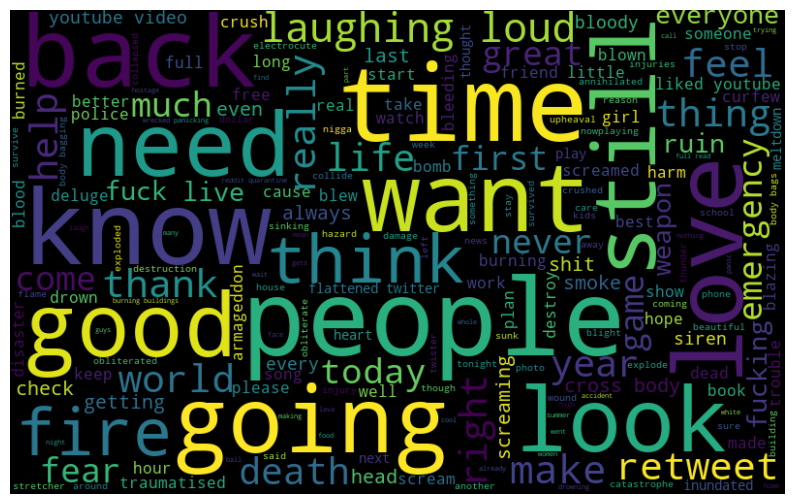

In [22]:
from wordcloud import WordCloud 
all_word = ' '.join([text for text in train[train['target']==0]['clean_text_join']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_word) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off') 
plt.show()

### (4) Vectorize words -- Word2Vec
### In order to vectorize words, Word2Vec is used.

In [23]:
from gensim.models import Word2Vec
EMBEDDING_DIM = 300

In [24]:
model = Word2Vec(sentences = train['clean_text_lst'], vector_size = EMBEDDING_DIM, window = 7, min_count = 1, sg = 1)
model.train(train['clean_text_lst'], total_examples=len(train['clean_text_lst']), epochs = 10)

(610143, 612980)

In [25]:
model.wv.most_similar("dead")

[('kaduna', 0.7760799527168274),
 ('shots', 0.7752063870429993),
 ('richmond', 0.7632631659507751),
 ('reportedly', 0.7556672096252441),
 ('exchanging', 0.7520483732223511),
 ('wounded', 0.7507103085517883),
 ('emmerdale', 0.7503719925880432),
 ('four', 0.7500960230827332),
 ('exchange', 0.7496474385261536),
 ('dozens', 0.7409618496894836)]

### (5) Tokenize words

In [26]:
#tokenizer = Tokenizer()
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(train['clean_text_lst'])
X_seq = tokenizer.texts_to_sequences(train['clean_text_lst'])
test_seq = tokenizer.texts_to_sequences(test['clean_text_lst'])

In [27]:
word_index = tokenizer.word_index
for word, num in word_index.items():
    if num == 20:
        break
    else:
        print(f"{word} ->{num}")

like ->1
fire ->2
people ->3
news ->4
video ->5
disaster ->6
emergency ->7
police ->8
would ->9
time ->10
body ->11
still ->12
back ->13
california ->14
storm ->15
burning ->16
crash ->17
know ->18
suicide ->19


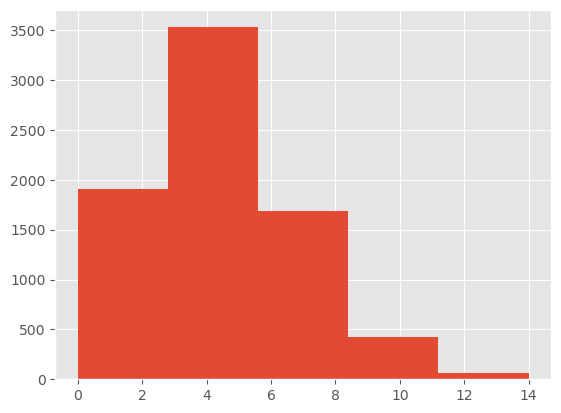

In [28]:
plt.hist([len(x) for x in X_seq], bins = 5)
plt.show()

In [29]:
#maxlen = 10
maxlen= 12
X_seq = pad_sequences(X_seq, maxlen=maxlen)
test_seq = pad_sequences(test_seq, maxlen=maxlen)

In [30]:
vocab_size = len(tokenizer.word_index) + 1

def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1

    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

embedding_vectors = get_weight_matrix(model, word_index)

In [31]:
embedding_vectors[3]

array([ 0.10522436,  0.26398477, -0.20431907, -0.0822182 , -0.11114263,
       -0.22107337, -0.17009135, -0.03938368, -0.29650262, -0.37075582,
        0.2884112 , -0.30107543,  0.25772202,  0.03186049, -0.25234109,
       -0.06899726,  0.25444916,  0.27927214,  0.32159147,  0.16774465,
       -0.19812952, -0.07069872,  0.37340522,  0.09754026,  0.19891961,
       -0.04973843, -0.17206699, -0.05048759, -0.0393406 , -0.26879326,
        0.04805157,  0.12321521,  0.06407665,  0.03101311,  0.04566734,
        0.18437491,  0.03662354, -0.27572781,  0.02955687, -0.19561692,
        0.33724278, -0.11967795,  0.34209189, -0.15808327,  0.38373816,
        0.1278201 , -0.13287869, -0.1766133 , -0.33501875,  0.02261451,
       -0.13326201,  0.31974652, -0.19095425,  0.11831808, -0.03664202,
       -0.10347832, -0.10097821, -0.46964571, -0.05534808, -0.13629687,
        0.10234635,  0.10852816, -0.16924906, -0.05528833,  0.08291537,
        0.11287813, -0.11762747, -0.05603846,  0.21441436, -0.23

## 2. Modeling
### (1) Base Model - LSTM

### Embedding vector made by Word2Vec is utilized for weight.

In [32]:
import tensorflow as tf
x_train, x_test, y_train, y_test = train_test_split(X_seq, train['target'], test_size=0.2, random_state=0)

In [33]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(vocab_size, output_dim = EMBEDDING_DIM, weights = [embedding_vectors], input_length = maxlen, trainable = False))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(LSTM(256))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(1, activation='sigmoid'))
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 12, 300)           4613700   
                                                                 
 dropout (Dropout)           (None, 12, 300)           0         
                                                                 
 lstm (LSTM)                 (None, 256)               570368    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 5,184,325
Trainable params: 570,625
Non-trainable params: 4,613,700
_________________________________________________________________


In [34]:
model_LSTM.compile(optimizer=keras.optimizers.Adam(lr=0.005), loss = 'binary_crossentropy', metrics = ['accuracy'])
history_LSTM = model_LSTM.fit(x_train, y_train, batch_size=64, validation_data=(x_test, y_test), epochs=20, verbose=1)

Epoch 1/20
96/96 [==============================] - 12s 91ms/step - loss: 0.5318 - accuracy: 0.7498 - val_loss: 0.4814 - val_accuracy: 0.7722
Epoch 2/20
96/96 [==============================] - 8s 80ms/step - loss: 0.4833 - accuracy: 0.7760 - val_loss: 0.4678 - val_accuracy: 0.7840
Epoch 3/20
96/96 [==============================] - 8s 79ms/step - loss: 0.4733 - accuracy: 0.7806 - val_loss: 0.4659 - val_accuracy: 0.7761
Epoch 4/20
96/96 [==============================] - 8s 80ms/step - loss: 0.4528 - accuracy: 0.7892 - val_loss: 0.4638 - val_accuracy: 0.7879
Epoch 5/20
96/96 [==============================] - 8s 85ms/step - loss: 0.4424 - accuracy: 0.7989 - val_loss: 0.4732 - val_accuracy: 0.7820
Epoch 6/20
96/96 [==============================] - 9s 90ms/step - loss: 0.4258 - accuracy: 0.8064 - val_loss: 0.4657 - val_accuracy: 0.7833
Epoch 7/20
96/96 [==============================] - 8s 82ms/step - loss: 0.4107 - accuracy: 0.8151 - val_loss: 0.4855 - val_accuracy: 0.7820
Epoch 8/20
9

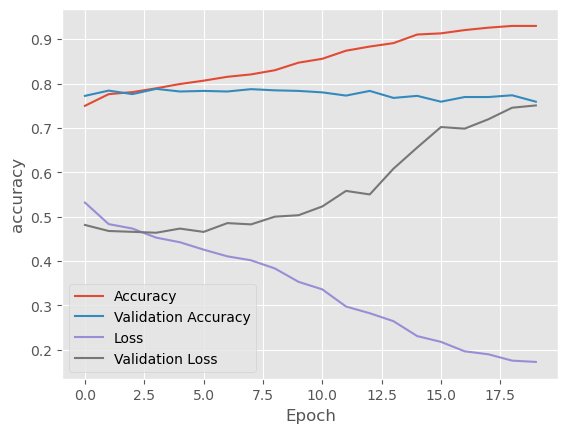

In [35]:
plt.plot(history_LSTM.history['accuracy'])
plt.plot(history_LSTM.history['val_accuracy'])
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.ylabel("accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy", "Loss", "Validation Loss"])
plt.show()


### Accuracy and validation accuracy are 0.9297, 0.7590 respectively. As validation accuracy might be getting slightly lower as the epoch proceed, some overfitting might occur.

### (2)  Bidirectional LSTM

In [36]:
model_BiLSTM = Sequential()
model_BiLSTM.add(Embedding(vocab_size, output_dim = EMBEDDING_DIM, weights = [embedding_vectors], input_length = maxlen, trainable = False))
model_BiLSTM.add(Bidirectional(LSTM(64, return_sequences = True)))
model_BiLSTM.add(Bidirectional(LSTM(32)))
model_BiLSTM.add(Dense(64, activation = 'relu'))
model_BiLSTM.add(Dense(1, activation='sigmoid'))
model_BiLSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 12, 300)           4613700   
                                                                 
 bidirectional (Bidirectiona  (None, 12, 128)          186880    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,846,021
Trainable params: 232,321
Non-

In [37]:
model_BiLSTM.compile(optimizer=keras.optimizers.Adam(lr=0.005), loss = 'binary_crossentropy', metrics = ['accuracy'])
history_BiLSTM = model_BiLSTM.fit(x_train, y_train, batch_size=64, validation_data=(x_test, y_test), epochs=20, verbose=1)

Epoch 1/20
96/96 [==============================] - 13s 63ms/step - loss: 0.5274 - accuracy: 0.7514 - val_loss: 0.4776 - val_accuracy: 0.7728
Epoch 2/20
96/96 [==============================] - 4s 41ms/step - loss: 0.4792 - accuracy: 0.7739 - val_loss: 0.4778 - val_accuracy: 0.7768
Epoch 3/20
96/96 [==============================] - 4s 41ms/step - loss: 0.4614 - accuracy: 0.7808 - val_loss: 0.4781 - val_accuracy: 0.7827
Epoch 4/20
96/96 [==============================] - 4s 41ms/step - loss: 0.4521 - accuracy: 0.7911 - val_loss: 0.4671 - val_accuracy: 0.7827
Epoch 5/20
96/96 [==============================] - 4s 41ms/step - loss: 0.4409 - accuracy: 0.7941 - val_loss: 0.4857 - val_accuracy: 0.7754
Epoch 6/20
96/96 [==============================] - 4s 42ms/step - loss: 0.4218 - accuracy: 0.8089 - val_loss: 0.4801 - val_accuracy: 0.7820
Epoch 7/20
96/96 [==============================] - 4s 43ms/step - loss: 0.4117 - accuracy: 0.8133 - val_loss: 0.4765 - val_accuracy: 0.7800
Epoch 8/20
9

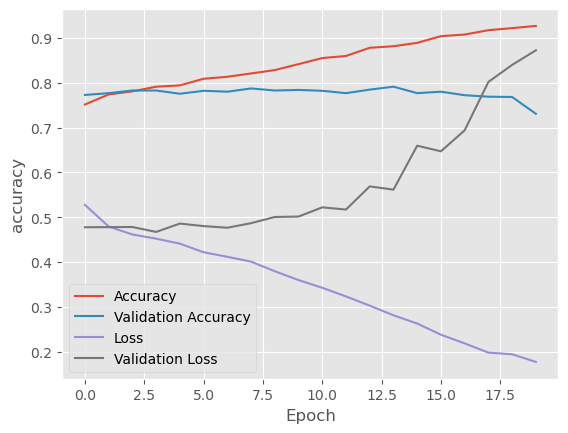

In [38]:
plt.plot(history_BiLSTM.history['accuracy'])
plt.plot(history_BiLSTM.history['val_accuracy'])
plt.plot(history_BiLSTM.history['loss'])
plt.plot(history_BiLSTM.history['val_loss'])
plt.ylabel("accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy", "Loss", "Validation Loss"])
plt.show()


### Accuracy and validation accuracy are 0.9268, 0.7308 respectively. Validation accuracy is getting lower as epoch proceeds. Some overfitting would occur.

### (3) GRU

In [39]:
model_GRU = Sequential()
model_GRU.add(Embedding(vocab_size, output_dim = EMBEDDING_DIM, weights = [embedding_vectors], input_length = maxlen, trainable = False))
model_GRU.add(Bidirectional(GRU(32)))
model_GRU.add(Dense(6, activation = 'relu'))
model_GRU.add(Dense(1, activation='sigmoid'))
model_GRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 12, 300)           4613700   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               64128     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
 dense_4 (Dense)             (None, 1)                 7         
                                                                 
Total params: 4,678,225
Trainable params: 64,525
Non-trainable params: 4,613,700
_________________________________________________________________


In [40]:
model_GRU.compile(optimizer=keras.optimizers.Adam(lr=0.005), loss = 'binary_crossentropy', metrics = ['accuracy'])
history_GRU = model_GRU.fit(x_train, y_train, batch_size=64, validation_data=(x_test, y_test), epochs=20, verbose=1)

Epoch 1/20
96/96 [==============================] - 7s 27ms/step - loss: 0.5301 - accuracy: 0.7460 - val_loss: 0.5279 - val_accuracy: 0.7452
Epoch 2/20
96/96 [==============================] - 2s 17ms/step - loss: 0.4905 - accuracy: 0.7691 - val_loss: 0.4740 - val_accuracy: 0.7768
Epoch 3/20
96/96 [==============================] - 2s 18ms/step - loss: 0.4657 - accuracy: 0.7841 - val_loss: 0.4858 - val_accuracy: 0.7715
Epoch 4/20
96/96 [==============================] - 2s 18ms/step - loss: 0.4532 - accuracy: 0.7887 - val_loss: 0.4731 - val_accuracy: 0.7774
Epoch 5/20
96/96 [==============================] - 2s 18ms/step - loss: 0.4366 - accuracy: 0.8007 - val_loss: 0.4916 - val_accuracy: 0.7728
Epoch 6/20
96/96 [==============================] - 2s 18ms/step - loss: 0.4287 - accuracy: 0.8057 - val_loss: 0.4871 - val_accuracy: 0.7748
Epoch 7/20
96/96 [==============================] - 2s 17ms/step - loss: 0.4095 - accuracy: 0.8171 - val_loss: 0.4815 - val_accuracy: 0.7741
Epoch 8/20
96

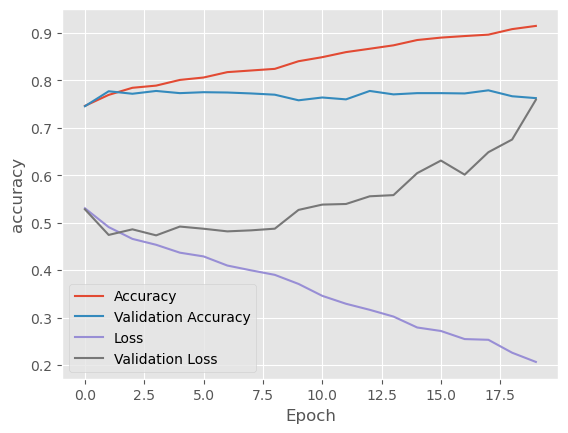

In [41]:
plt.plot(history_GRU.history['accuracy'])
plt.plot(history_GRU.history['val_accuracy'])
plt.plot(history_GRU.history['loss'])
plt.plot(history_GRU.history['val_loss'])
plt.ylabel("accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy", "Loss", "Validation Loss"])
plt.show()


### Accuracy and validation accuracy are 0.9144, 0.7623 respectively.

## 3. Analysis
### 3 models (LSTM, BiDirectional LSTM, GRU(Gated Recurrent Unit) are tried. With regard  to accuracy, LSTM is the best (0.9297), a little better than BiDirectional LSTM (0.9268). But at BiDirectional LSTM, loss increses heavier than at LSTM, as epoc proceeds.
### In this regard, LSTM is a well-fitted model for disaster tweet classification among 3 models.

## 4. Conclusion

### In this NLP Disaster Tweet Kaggle Mini-Project, among 3 models, LSTM is concluded to be the best-fitted model. But even if accuracy of this model is 0.9297, public score is 0.75206 at the Kaggle leaderboard. 
### In order to improve the score, text cleaning would be the key. In my mini-project, text-cleaning is rendered on-site, but I guess there could be more characters in tweet. In this regard, there is some room to improve in text cleaning.

## Submission

In [42]:
test_pred = model_LSTM.predict(test_seq).reshape((3263,))
test['prediction'] = test_pred
test['target'] = np.where(test['prediction']>0.5,1,0)

102/102 [==============================] - 3s 22ms/step


In [43]:
test['target'].value_counts()

0    2039
1    1224
Name: target, dtype: int64

In [44]:
test.head()

,id,keyword,location,text,clean_text,clean_text2,clean_text3,tokenize,clean_text_lst,clean_text_join,prediction,target
0,0,NaN,NaN,Just happened a terrible car crash,Just happened a terrible car crash,Just happened a terrible car crash,just happened terrible crash,"[just, happened, terrible, crash]","[happened, terrible, crash]",happened terrible crash,0.054858,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","Heard about # earthquake is different cities,...","Heard about # earthquake is different cities ,...",heard about earthquake different cities stay s...,"[heard, about, earthquake, different, cities, ...","[heard, earthquake, different, cities, stay, s...",heard earthquake different cities stay safe ev...,0.997473,1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond , geese ar...",there forest fire spot pond geese fleeing acro...,"[there, forest, fire, spot, pond, geese, fleei...","[forest, fire, spot, pond, geese, fleeing, acr...",forest fire spot pond geese fleeing across str...,0.033489,0
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting . # Spokane # wildfires,Apocalypse lighting . # Spokane # wildfires,apocalypse lighting spokane wildfires,"[apocalypse, lighting, spokane, wildfires]","[apocalypse, lighting, spokane, wildfires]",apocalypse lighting spokane wildfires,0.530683,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills china taiwan,"[typhoon, soudelor, kills, china, taiwan]","[typhoon, soudelor, kills, china, taiwan]",typhoon soudelor kills china taiwan,0.999960,1


In [45]:
test1 = test.loc[:,['id','target']]
test1

,id,target
0,0,0
1,2,1
2,3,0
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [46]:
test1.to_csv('submission.csv', index=False)

### Reference
#### https://www.kaggle.com/code/alehandro35/word2vec-vs-glove-in-tweet-classification
#### https://www.kaggle.com/code/ankitp013/classifying-disaster-tweets-using-lstm
#### https://www.kaggle.com/code/akashkr/tf-keras-tutorial-bi-lstm-glove-gru-part-6
#### https://www.kaggle.com/code/rftexas/text-only-bert-keras?scriptVersionId=31186559